# Chapter 6 - Artefact segmentation

The artefact dataset (Block A/B/C WSIs and validation tiles) is available from [Zenodo](https://zenodo.org/record/3773097), and needs to be downloaded to run this notebook.

In [9]:
import pickle
import os

import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from skimage.io import imread
from datasets.artefact import get_tissue_mask, get_visualisation_supervised

## Dataset imbalance

Computed at 1.25x magnification

### Training set

In [13]:
dataset_dir = "e:/data/artefact-lisa/train" # to replace with extracted folder for the dataset

images_125 = [f for f in os.listdir(dataset_dir) if f.endswith('1.25_rgb.png')]
masks_125 = [f.replace('rgb', 'mask') for f in images_125]

In [16]:
tot_pixels_pos = 0
tot_pixels_tissue = 0

for f, m in zip(images_125, masks_125):
    im = imread(os.path.join(dataset_dir, f))[..., :3]
    tissue_mask = get_tissue_mask(im)
    gt_mask = imread(os.path.join(dataset_dir, m))>0
    tot_pixels_tissue += tissue_mask.sum()
    tot_pixels_pos += (gt_mask*tissue_mask).sum()
    print(tot_pixels_pos, tot_pixels_tissue)

3299 7041132
84713 14232229
102760 21389801
171745 28589348
248154 35645847
282088 42805957
490678 49856211
545680 56994539
604183 63778278
821673 70849492
1078614 77363119
1252557 84206375
1479281 91082804
1719486 97971197
1911497 105511954
2026917 112224780
2116825 119046552
2218798 125942400


In [17]:
print(f"% positive pixels (training set): {(tot_pixels_pos/tot_pixels_tissue)*100:.2f}")

% positive pixels (training set): 1.76


### Validation set

In [18]:
dataset_dir = "e:/data/artefact-lisa/validation"

images_125 = [f for f in os.listdir(dataset_dir) if f.endswith('1.25_rgb.png')]
masks_125 = [f.replace('rgb', 'mask') for f in images_125]

In [19]:
tot_pixels_pos = 0
tot_pixels_tissue = 0

for f, m in zip(images_125, masks_125):
    im = imread(os.path.join(dataset_dir, f))[..., :3]
    tissue_mask = get_tissue_mask(im)
    gt_mask = imread(os.path.join(dataset_dir, m))>0
    tot_pixels_tissue += tissue_mask.sum()
    tot_pixels_pos += (gt_mask*tissue_mask).sum()
    print(tot_pixels_pos, tot_pixels_tissue)

print(f"% positive pixels (validation set): {(tot_pixels_pos/tot_pixels_tissue)*100:.2f}")

6068 7320747
428017 14847766
1657041 22027896
% positive pixels (validation set): 7.52


### Test slide

In [20]:
dataset_dir = "e:/data/artefact-lisa/test"

images_125 = [f for f in os.listdir(dataset_dir) if f.endswith('1.25_rgb.png')]
masks_125 = [f.replace('rgb', 'mask') for f in images_125]

In [21]:
tot_pixels_pos = 0
tot_pixels_tissue = 0

for f, m in zip(images_125, masks_125):
    im = imread(os.path.join(dataset_dir, f))[:, :4000, :3]
    tissue_mask = get_tissue_mask(im)[:, :4000]
    gt_mask = imread(os.path.join(dataset_dir, m))[:, :4000]>0
    tot_pixels_tissue += tissue_mask.sum()
    tot_pixels_pos += (gt_mask*tissue_mask).sum()
    print(tot_pixels_pos, tot_pixels_tissue)

print(f"% positive pixels (test slide): {(tot_pixels_pos/tot_pixels_tissue)*100:.2f}")

554412 6222942
% positive pixels (test slide): 8.91


## Positive & negative tiles

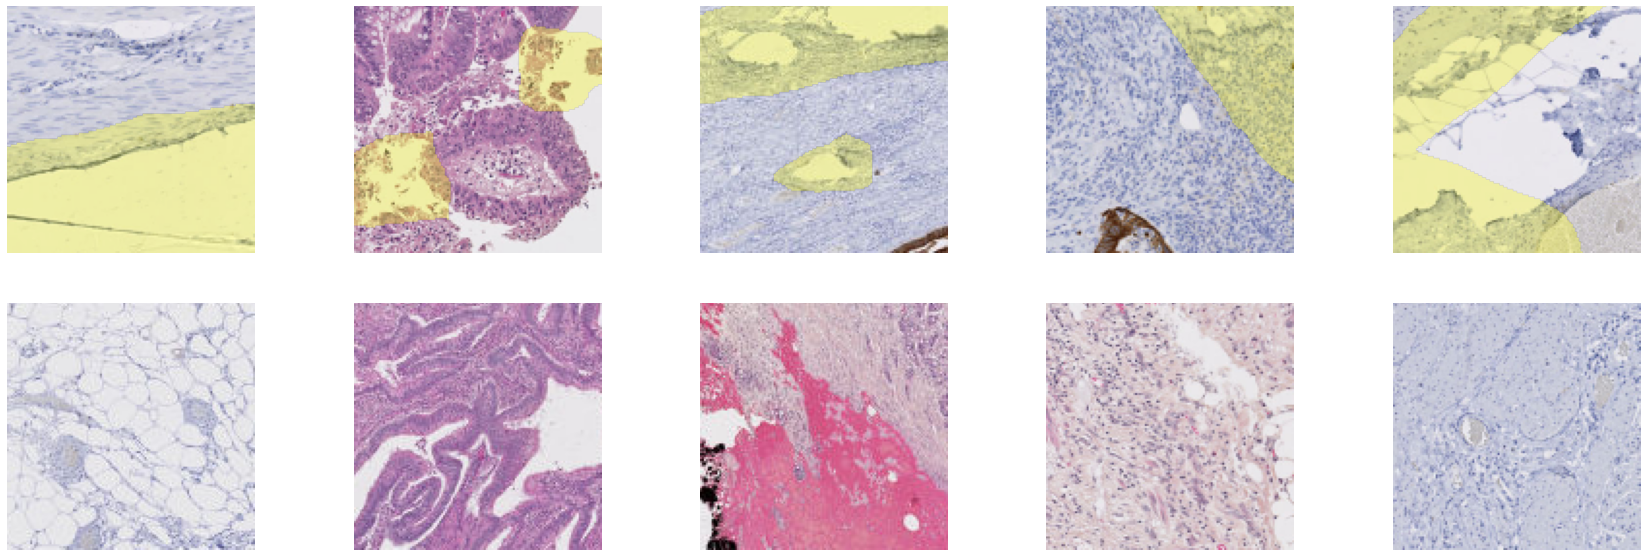

In [42]:
plt.figure(figsize=(30,10))
for i in range(5):
    im = imread(f'./data/artefact_tile_pos_{i+1}_rgb.png')
    anno = imread(f'./data/artefact_tile_pos_{i+1}_anno.png')>0
    anno_rgba = np.zeros((im.shape[0], im.shape[1], 4))
    anno_rgba[anno] = np.array((1., 1., 0, 0.3))
    plt.subplot(2, 5, i+1)
    plt.imshow(im)
    plt.imshow(anno_rgba)
    plt.axis('off')
for i, (im, anno) in enumerate(neg):
    im = imread(f'./data/artefact_tile_neg_{i+1}_rgb.png')
    anno = imread(f'./data/artefact_tile_neg_{i+1}_anno.png')>0
    anno_rgba = np.zeros((im.shape[0], im.shape[1], 4))
    anno_rgba[anno] = np.array((1., 1., 0, 0.3))
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(im)
    plt.imshow(anno_rgba)
    plt.axis('off')
plt.show()

## SNOW experiments results

Raw results can be downloaded as a ZIP file from: 

### Similarity between algorithms on the Artefact dataset

* Compute DSC, MCC and cross-entropy between all pairs of networks.
* Show corresponding MDS visualisation

In [43]:
from sklearn.manifold import MDS
from metrics.segmentation import DSC, MCC_segmentation
from datasets.artefact import load_predictions_SNOW

In [44]:
RESULTS_DIR = "E:/pCloud/ULB/Doctorat/workspace/SNOW/results_artefact"

def compare_CE(A, B):
    return -np.mean(0.5*(A*np.log(B)+B*np.log(A)))

In [4]:
networks = ['pan', 'shortres', 'unet']
marks = ['s', 'o', 'd']
strategies = ['baseline', 'gsn50', 'onlyP']
colors = ['k', 'r', 'b']

prob_maps = load_predictions_SNOW(RESULTS_DIR)

list_combinations = []
labels = []
markers = []

for i,net in enumerate(networks):
    for j,strat in enumerate(strategies):
        list_combinations.append(prob_maps[net][strat])
        labels.append(f"{net}-{strat}")
        markers.append(f"{marks[i]}{colors[j]}")

for i, lab in enumerate(labels):
    labels[i] = lab.replace('gsn', 'ga')

In [14]:
def display_similarity_matrix(matrix, title, threshold_black = 0.5):
    plt.figure(figsize=(14,14))
    plt.imshow(matrix, interpolation='none', cmap=plt.cm.coolwarm)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if i <= j:
                color = 'k'
                plt.text(j, i, f'{matrix[i, j]:.3f}', ha="center", va="center", color=color, fontsize='xx-large')
        plt.xticks(range(matrix.shape[1]), labels=labels, fontsize='xx-large', rotation = 45)
        plt.yticks(range(matrix.shape[0]), labels=labels, fontsize='xx-large')
        plt.title(title, fontsize='xx-large')
    plt.show()
    
def compute_and_show_mds(matrix, title):
    diss = 1-matrix
    
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=15)
    coords = mds.fit_transform(diss)

    plt.figure(figsize=(10,10))
    for i in range(coords.shape[0]):
        plt.plot(coords[i, 0], coords[i, 1], markers[i], label=labels[i])
    plt.legend(fontsize='large')
    plt.title(title, fontsize='xx-large')
    plt.show()

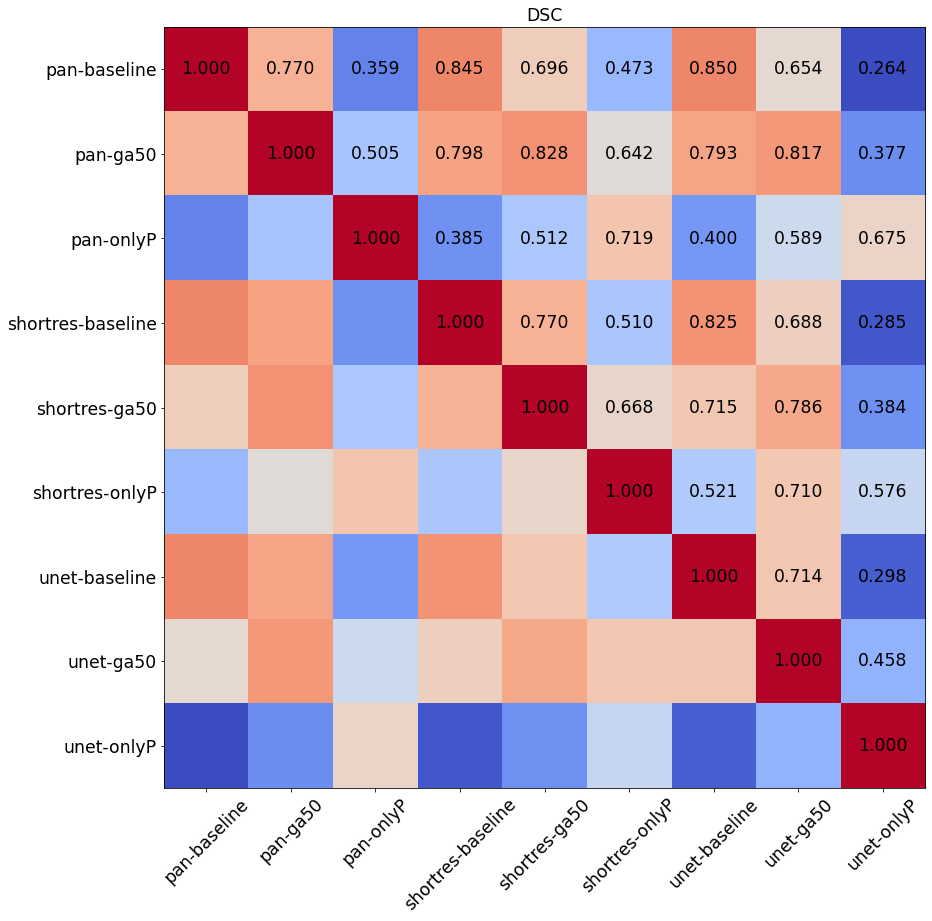

In [13]:
comparisons = np.zeros((9, 9))

for i in range(len(list_combinations)):
    for j in range(len(list_combinations)):
        predictions_A = np.hstack(list_combinations[i])
        predictions_B = np.hstack(list_combinations[j])
        comparisons[i, j] = DSC(predictions_A>=0.5, predictions_B>=0.5)
        comparisons[j, i] = comparisons[i, j]
display_similarity_matrix(comparisons, 'DSC')

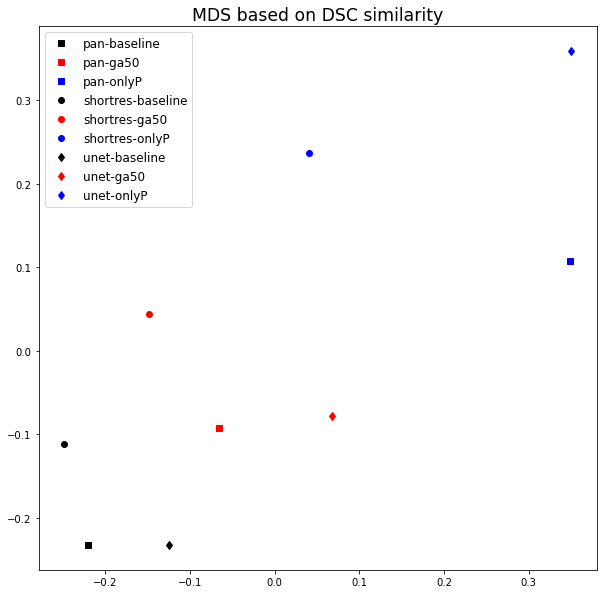

In [15]:
compute_and_show_mds(comparisons, "MDS based on DSC similarity")

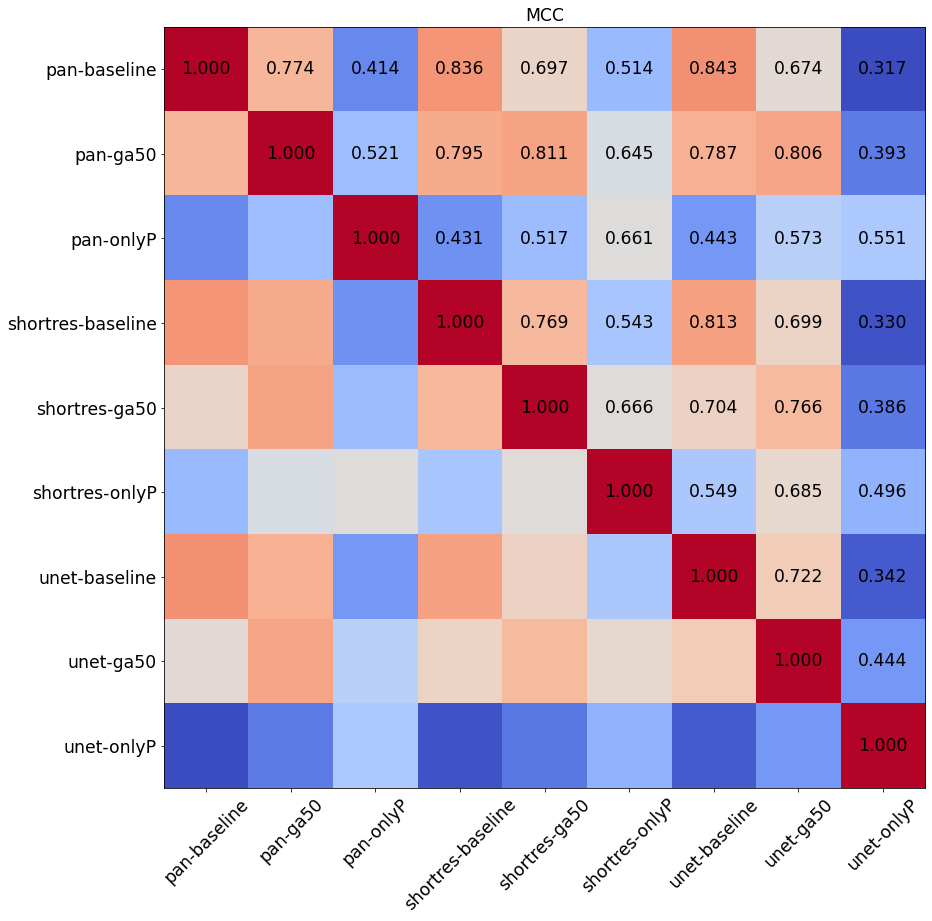

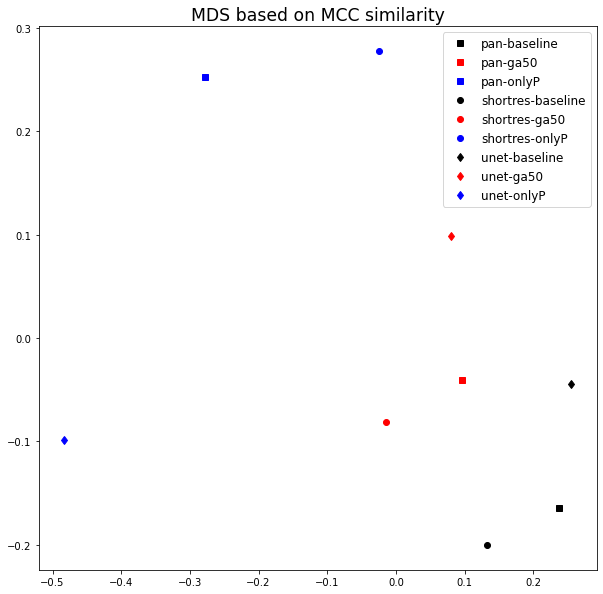

In [16]:
comparisons_mcc = np.zeros((9, 9))
for i in range(len(list_combinations)):
    for j in range(len(list_combinations)):
        predictions_A = np.hstack(list_combinations[i])
        predictions_B = np.hstack(list_combinations[j])
        comparisons_mcc[i, j] = MCC_segmentation(predictions_A>=0.5, predictions_B>=0.5)
        comparisons_mcc[j, i] = comparisons_mcc[i, j]
    
display_similarity_matrix(comparisons_mcc, 'MCC')
compute_and_show_mds(comparisons_mcc, "MDS based on MCC similarity")

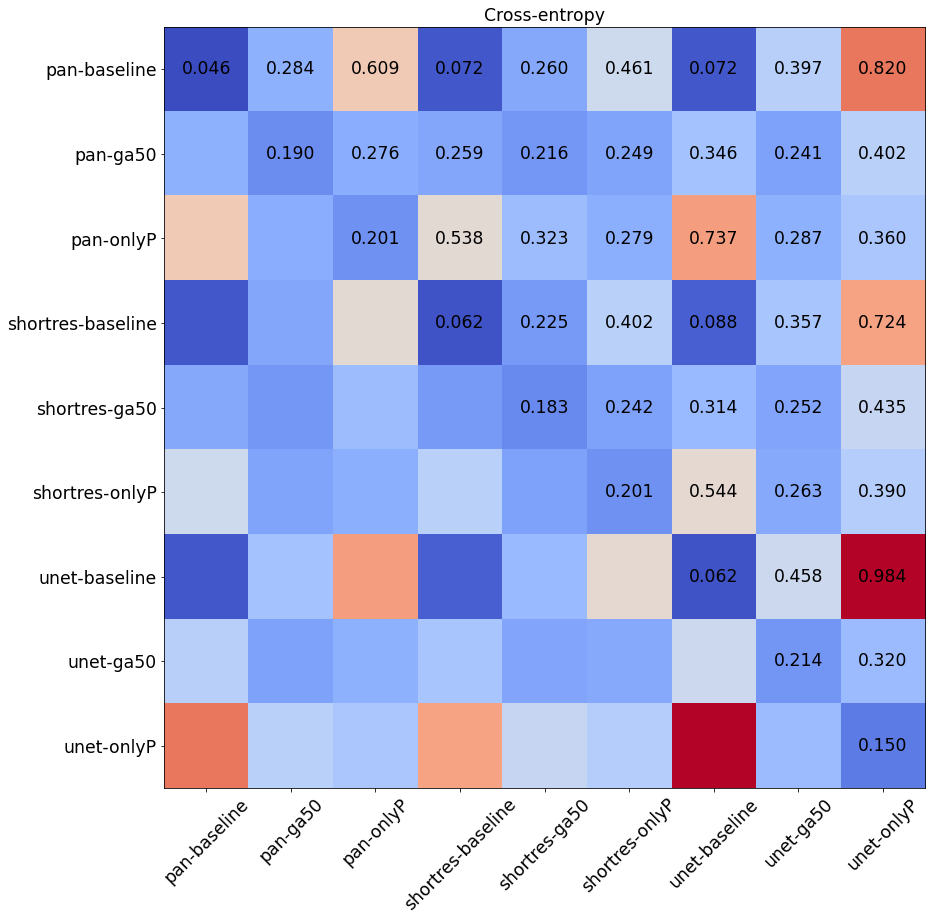

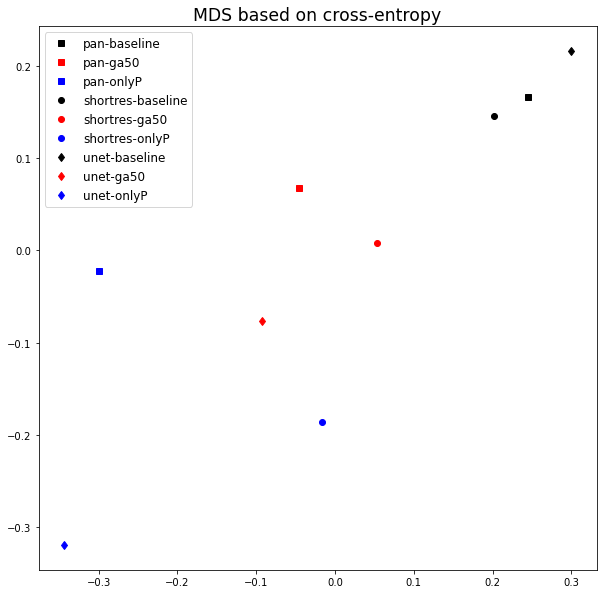

In [17]:
comparisons_ce = np.zeros((9, 9))
for i in range(len(list_combinations)):
    for j in range(len(list_combinations)):
        predictions_A = np.hstack(list_combinations[i])
        predictions_B = np.hstack(list_combinations[j])
        comparisons_ce[i, j] = compare_CE(predictions_A+1e-10, predictions_B+1e-10)
        comparisons_ce[j, i] = comparisons_ce[i, j]
        
display_similarity_matrix(comparisons_ce, 'Cross-entropy')
compute_and_show_mds((comparisons_ce.max()-comparisons_ce)/(comparisons_ce.max()-comparisons_ce.min()), 'MDS based on cross-entropy')